In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.preprocessing import LabelEncoder

# Predicting Diabetes Based on Key Symptoms

The dataset used for this analysis is available on Kaggle: [Early Stage Diabetes Risk Prediction](https://www.kaggle.com/datasets/abdelazizsami/early-stage-diabetes-risk-prediction). I begin by loading it into a dataframe.

In [32]:
df = pd.read_csv("diabetes.csv")
train_df, test_df = train_test_split(df, random_state=111)
train_df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
367,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,Yes,No,No,Positive
145,61,Male,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Positive
258,35,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
238,72,Male,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Negative
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive


## EDA

Before predicting, I will first explore the data to determine whether any values are missing, and to determine the type of each feature.

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 367 to 86
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 390 non-null    int64 
 1   Gender              390 non-null    object
 2   Polyuria            390 non-null    object
 3   Polydipsia          390 non-null    object
 4   sudden weight loss  390 non-null    object
 5   weakness            390 non-null    object
 6   Polyphagia          390 non-null    object
 7   Genital thrush      390 non-null    object
 8   visual blurring     390 non-null    object
 9   Itching             390 non-null    object
 10  Irritability        390 non-null    object
 11  delayed healing     390 non-null    object
 12  partial paresis     390 non-null    object
 13  muscle stiffness    390 non-null    object
 14  Alopecia            390 non-null    object
 15  Obesity             390 non-null    object
 16  class               390 non-nu

Since none of the features are missing any values, there is no need for imputation for any of the features. It looks like `Age` is a numeric feature, and everything else is a feature representing whether a particular symptom was observed. None of the features seem to be unique identifiers or otherwise irrelevant to diabetes status, so all the features will be retained. For my analysis, I will be trying to predict `class` which denotes whether the individual with that particular set of symptoms was diagnosed with diabetes.

In [34]:
numeric_features = ["Age"]
target_column = ["class"]
binary_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(target_column)
)

For the sole numeric feature, I will use `StandardScaler` so that the magnitude does not affect the analysis (this will not be relevant for some of the models). For the remaining features, I will use `OneHotEncoder` to convert them from "Yes"/"No" to a numerical representation.

In [35]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop = "if_binary"), binary_features),
)

To see what the data looks like after processing, I'll fit it here:

In [36]:
preprocessor.fit(train_df);

X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns = (numeric_features + binary_features)
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns = (numeric_features + binary_features)
)

At this point, I will also use `LabelEncoder` to transform the target, `class`, from text answers to a numerical representation (necessary for certain models).

In [37]:
le = LabelEncoder()
y_train = train_df['class']
y_test = test_df['class']
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

A quick look at the processed data:

In [38]:
X_train_enc.head()

,Age,Polyuria,Polydipsia,sudden weight loss,muscle stiffness,Gender,visual blurring,weakness,Alopecia,Polyphagia,Genital thrush,partial paresis,Obesity,Irritability,delayed healing,Itching
367,-0.697284,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
145,1.046992,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
258,-1.112588,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
238,1.960660,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
517,0.797809,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


Before moving on to the actual models that I will be using to make the predictions, I will quickly check how many people in the dataset were diagnosed with diabetes. If the dataset is highly skewed, the default metric (accuracy, or correct predictions out of the total) may not be suitable.

In [39]:
train_df['class'].value_counts()

class
Positive    244
Negative    146
Name: count, dtype: int64

Out of 390 individuals in this dataset, 244 (or about 63%) had diabetes. This indicates a significant skew, but not enough to render `accuracy` unhelpful in determining how well different models perform on the dataset.

## Models

Below, I have included a useful helper function from my machine learning course at UBC. It can be found in a public GitHub repo here: https://github.com/UBC-CS/cpsc330-2023W2/blob/main/hw/hw3/hw3.ipynb.

In [40]:
# Helper function from CPSC330: Applied Machine Learning at UBC, available here:
# https://github.com/UBC-CS/cpsc330-2023W2/blob/main/hw/hw3/hw3.ipynb 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Baseline Model

For the baseline, I will use scikit-learn's `DummyClassifier` to make an initial prediction. Since it just takes the most frequent class in the target, there is no need to put it through the preprocessor.

In [41]:
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]

In [42]:
results = {}
dummy = DummyClassifier(strategy="most_frequent")
results["dummy"] = mean_std_cross_val_scores(dummy, X_train, y_train, cv = 5, return_train_score=True)
display(pd.DataFrame(results).T)

dummy.fit(X_train, y_train)
matrix = confusion_matrix(y_train, dummy.predict(X_train))

C:\Users\simar\AppData\Local\Temp\ipykernel_11636\2179986651.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.002),0.001 (+/- 0.003),0.626 (+/- 0.006),0.626 (+/- 0.001)


### Other Models

With a baseline established, a more complex but still interpretable model is `LogisticRegression`. Let's give it a try.

In [44]:
param_dist = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=10000))

random_search = RandomizedSearchCV(pipe,
                  random_state = 111,
                  param_distributions = param_dist, 
                  n_iter=100, 
                  return_train_score=True)

random_search.fit(X_train, y_train)
lr_best_score = random_search.best_score_
lr_best_params = random_search.best_params_
print(lr_best_score)
print(lr_best_params)

C:\Users\simar\anaconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.9205128205128205
{'logisticregression__C': 1}


In [45]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=10000, C=lr_best_params['logisticregression__C']))
results["LogisticRegression"] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5,return_train_score=True)
display(pd.DataFrame(results).T)

C:\Users\simar\AppData\Local\Temp\ipykernel_11636\2179986651.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.002),0.001 (+/- 0.003),0.626 (+/- 0.006),0.626 (+/- 0.001)
LogisticRegression,0.014 (+/- 0.004),0.004 (+/- 0.003),0.921 (+/- 0.019),0.945 (+/- 0.008)


Another common model for classification is `RandomForest`.

In [50]:
param_dist = {
    "randomforestclassifier__max_depth": [None, 1, 5, 10, 50, 100, 200, 500],
    "randomforestclassifier__max_features": ["sqrt", "log2", None], 
    "randomforestclassifier__n_estimators": range(1, 501, 10)  
    
}

pipe = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1))

random_search = RandomizedSearchCV(pipe,  
                  random_state = 111,
                  param_distributions = param_dist, 
                  n_iter=100, 
                  n_jobs=-1, 
                  return_train_score=True)

random_search.fit(X_train, y_train)
rf_best_score = random_search.best_score_
rf_best_params = random_search.best_params_
print(rf_best_score)
print(rf_best_params)

0.9717948717948719
{'randomforestclassifier__n_estimators': 351, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10}


In [51]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, 
                                                        max_depth = rf_best_params['randomforestclassifier__max_depth'],
                                                        max_features = rf_best_params["randomforestclassifier__max_features"],
                                                        n_estimators = rf_best_params["randomforestclassifier__max_depth"]))

results["RandomForestClassifier"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

C:\Users\simar\AppData\Local\Temp\ipykernel_11636\2179986651.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.002),0.001 (+/- 0.003),0.626 (+/- 0.006),0.626 (+/- 0.001)
LogisticRegression,0.014 (+/- 0.004),0.004 (+/- 0.003),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForestClassifier,0.017 (+/- 0.001),0.010 (+/- 0.001),0.964 (+/- 0.025),0.997 (+/- 0.003)


From the cross-validation accuracy, it can be seen`RandomForest` performs significantly better than the dummy and the previous model tried, `LogisticRegression`. However, it is possible that a gradient-boosted model could still do better, next I will try one more model.

In [52]:
from catboost import CatBoostClassifier
from scipy.stats import randint

param_dist = {
    "catboostclassifier__learning_rate": np.linspace(0,0.2,5),
    "catboostclassifier__max_depth": randint(3, 10)
}

pipe = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=111))

random_search = RandomizedSearchCV(pipe,
                  random_state = 111,                 
                  param_distributions = param_dist, 
                  n_iter=10, 
                  return_train_score=True)

random_search.fit(X_train, y_train_enc)
cb_best_score = random_search.best_score_
cb_best_params = random_search.best_params_
print(cb_best_score)
print(cb_best_params)

C:\Users\simar\anaconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simar\anaconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simar\anaconda3\envs\cpsc330\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\simar\anaconda3\envs\cpsc330\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

0.976923076923077
{'catboostclassifier__learning_rate': 0.2, 'catboostclassifier__max_depth': 9}


In [53]:
cb = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, 
                                                             random_state=111, 
                                                             learning_rate = cb_best_params['catboostclassifier__learning_rate'],
                                                             max_depth = cb_best_params['catboostclassifier__max_depth']))

results["CatBoostClassifier"] = mean_std_cross_val_scores(cb, X_train, y_train, cv=5, return_train_score=True)
display(pd.DataFrame(results).T)

C:\Users\simar\AppData\Local\Temp\ipykernel_11636\2179986651.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.002),0.001 (+/- 0.003),0.626 (+/- 0.006),0.626 (+/- 0.001)
LogisticRegression,0.014 (+/- 0.004),0.004 (+/- 0.003),0.921 (+/- 0.019),0.945 (+/- 0.008)
RandomForestClassifier,0.017 (+/- 0.001),0.010 (+/- 0.001),0.964 (+/- 0.025),0.997 (+/- 0.003)
CatBoostClassifier,4.417 (+/- 0.179),0.007 (+/- 0.001),0.977 (+/- 0.019),1.000 (+/- 0.000)


## Final Model

After determining that `CatBoostClassifier` seems to perform the best out of the models tried, I will test its performance on the test data.

In [54]:
final_model = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, 
                                                             random_state=111, 
                                                             learning_rate = cb_best_params['catboostclassifier__learning_rate'],
                                                             max_depth = cb_best_params['catboostclassifier__max_depth']))
final_model.fit(X_train, y_train_enc)
test_score = final_model.score(X_test, y_test_enc)
print(test_score)

0.9692307692307692


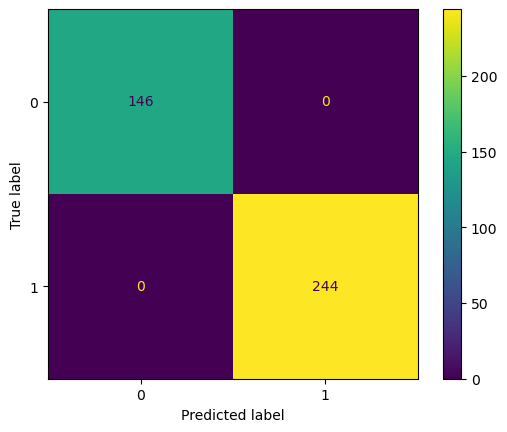

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
matrix = confusion_matrix(y_train_enc, final_model.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()